In [1]:
%matplotlib inline


Univariate analysis of block design, one condition versus rest, single subject
==============================================================================

Authors: Bertrand Thirion, dohmatob elvis dopgima, Christophe Pallier, 2015--2017



In this tutorial, we compare the fMRI signal during periods of auditory stimulation
versus periods of rest, using a General Linear Model (GLM). We will
use a univariate approach in which independent tests are performed at
each single-voxel.

The dataset comes from experiment conducted at the FIL by Geriant Rees
under the direction of Karl Friston. It is provided by FIL methods
group which develops the SPM software.

According to SPM documentation, 96 acquisitions were made (RT=7s), in
blocks of 6, giving 16 42s blocks. The condition for successive blocks
alternated between rest and auditory stimulation, starting with rest.
Auditory stimulation was bi-syllabic words presented binaurally at a
rate of 60 per minute. The functional data starts at acquisiton 4,
image fM00223_004.

The whole brain BOLD/EPI images were acquired on a modified 2T Siemens
MAGNETOM Vision system. Each acquisition consisted of 64 contiguous
slices (64x64x64 3mm x 3mm x 3mm voxels). Acquisition took 6.05s, with
the scan to scan repeat time (RT) set arbitrarily to 7s.


This analyse described here is performed in the native space, on the
original EPI scans without any spatial or temporal preprocessing.
(More sensitive results would likely be obtained on the corrected,
spatially normalized and smoothed images).


To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use the Jupyter notebook.
    :depth: 1




Retrieving the data
-------------------

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we load the data using a data downloading
          function.To input your own data, you will need to pass
          a list of paths to your own files.</p></div>



In [2]:
import nistats
nistats.__version__


'0.0.1a'

In [3]:
from nistats.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()

We can list the filenames of the functional images



In [4]:
subject_data

{'anat': '/Users/Ralf/nilearn_data/spm_auditory/sub001/sM00223/sM00223_002.img',
 'func': ['/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
  '/Users/Ralf/nilearn_

In [5]:
print(subject_data.func)

['/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img', '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_0

Display the first functional image:



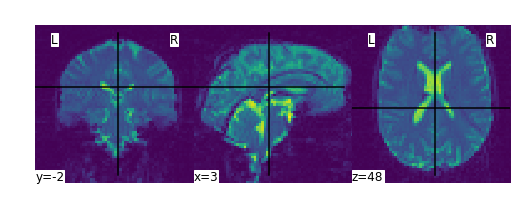

In [6]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
plot_img(subject_data.func[0])

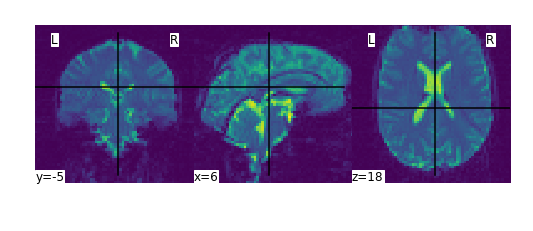

In [33]:
import nibabel as nib
import nilearn
f2 = '/Users/Ralf/Desktop/MoAEpilot/fM00223/f.nii.gz'
f2nii = nib.load(f2)
#lot_img(f2)
f21 = nilearn.image.index_img(f2,0)
f21
plot_img(f21)

Display the subject's anatomical image:



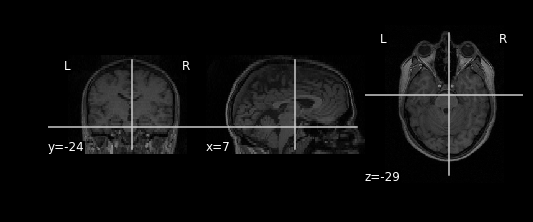

In [7]:
plot_anat(subject_data.anat)

Next, we concatenate all the 3D EPI image into a single 4D image:



In [34]:
from nilearn.image import concat_imgs
fmri_img = concat_imgs(subject_data.func)
fmri_img.shape

(64, 64, 64, 96)

And we average all the EPI images in order to create a background
image that will be used to display the activations:



In [47]:
from nilearn import image
mean_img = image.mean_img(f2)

Specifying the experimental paradigm
------------------------------------

We must provide a description of the experiment, that is, define the
timing of the auditory stimulation and rest periods. According to
the documentation of the dataset, there were 16 42s blocks --- in
which 6 scans were acquired --- alternating between rest and
auditory stimulation, starting with rest. We use standard python
functions to create a pandas.DataFrame object that specifies the
timings:



In [10]:
import numpy as np
tr = 7.
slice_time_ref = 0.
n_scans = 96
epoch_duration = 6 * tr  # duration in seconds
conditions = ['rest', 'active'] * 8
n_blocks = len(conditions)
duration = epoch_duration * np.ones(n_blocks)
onset = np.linspace(0, (n_blocks - 1) * epoch_duration, n_blocks)

import pandas as pd
events = pd.DataFrame({'onset': onset, 'duration': duration, 'trial_type': conditions})

The ``events`` object contains the information for the design:



In [11]:
print(events)

    duration  onset trial_type
0       42.0    0.0       rest
1       42.0   42.0     active
2       42.0   84.0       rest
3       42.0  126.0     active
4       42.0  168.0       rest
5       42.0  210.0     active
6       42.0  252.0       rest
7       42.0  294.0     active
8       42.0  336.0       rest
9       42.0  378.0     active
10      42.0  420.0       rest
11      42.0  462.0     active
12      42.0  504.0       rest
13      42.0  546.0     active
14      42.0  588.0       rest
15      42.0  630.0     active


Performing the GLM analysis
---------------------------

We need to construct a *design matrix* using the timing information
provided by the ``events`` object. The design matrix contains
regressors of interest as well as regressors of non-interest
modeling temporal drifts:



In [12]:
frame_times = np.linspace(0, (n_scans - 1) * tr, n_scans)
drift_model = 'Cosine'
period_cut = 4. * epoch_duration
hrf_model = 'glover + derivative'

It is now time to create a ``FirstLevelModel`` object
and fit it to the 4D dataset:



In [41]:
from nistats.first_level_model import FirstLevelModel

fmri_glm2 = FirstLevelModel(tr, slice_time_ref, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model, period_cut=period_cut)
fmri_glm2 = fmri_glm2.fit(f2, events)

/Users/Ralf/.local/lib/python3.6/site-packages/nistats-0.0.1a0-py3.6.egg/nistats/experimental_paradigm.py:57: UserWarning: 'trial_type' key not found in the given paradigm.
  warnings.warn("'trial_type' key not found in the given paradigm.")
/Users/Ralf/.local/lib/python3.6/site-packages/nistats-0.0.1a0-py3.6.egg/nistats/experimental_paradigm.py:60: UserWarning: 'duration' key not found in the given paradigm.
  warnings.warn("'duration' key not found in the given paradigm.")


One can inspect the design matrix (rows represent time, and
columns contain the predictors):



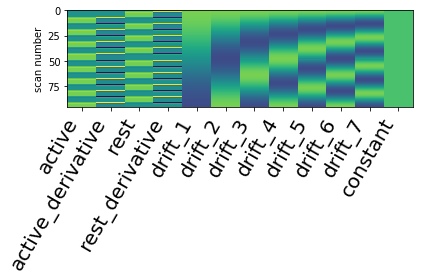

In [42]:
from nistats.reporting import plot_design_matrix
design_matrix2 = fmri_glm2.design_matrices_[0]
plot_design_matrix(design_matrix)

The first column contains the expected reponse profile of regions which are
sensitive to the auditory stimulation.



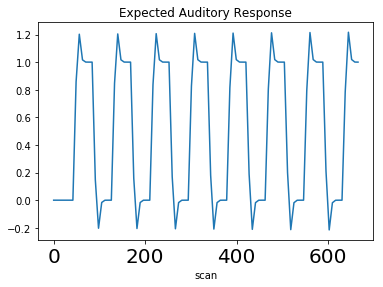

In [43]:
import matplotlib.pyplot as plt
plt.plot(design_matrix2['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we
created constrasts with a single '1' in each of the columns:



In [44]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix2.columns)])

"""
contrasts::

  {
  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  'rest':              array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'rest_derivative':   array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}
"""

"\ncontrasts::\n\n  {\n  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),\n  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),\n  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),\n  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),\n  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),\n  'rest':              array([ 0.,  0.,  1.,  0

We can then compare the two conditions 'active' and 'rest' by
generating the relevant contrast:



In [45]:
active_minus_rest =  contrasts['active'] - contrasts['rest']

eff_ma2p = fmri_glm2.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

z_map2 = fmri_glm2.compute_contrast(active_minus_rest,
                                  output_type='z_score')

Plot thresholded z scores map



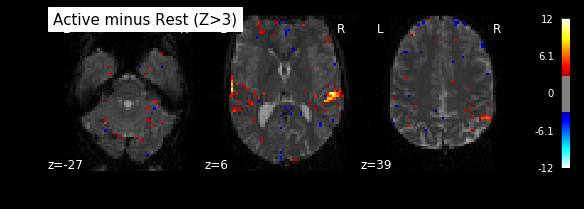

In [48]:
plot_stat_map(z_map2, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)')

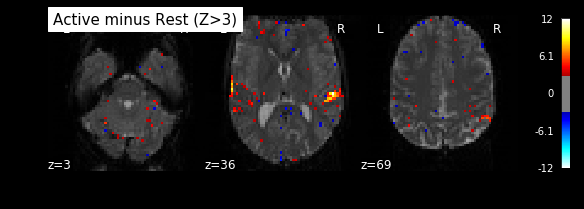

In [18]:
plot_stat_map(z_map2, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)')

We can use ``nibabel.save`` to save the effect and zscore maps to the disk



In [19]:
import os
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

import nibabel
from os.path import join
nibabel.save(z_map, join('results', 'active_vs_rest_z_map.nii'))
nibabel.save(eff_map, join('results', 'active_vs_rest_eff_map.nii'))

Extract the signal from a voxels
 --------------------------------

We search for the voxel with the larger z-score and plot the signal
(warning: double dipping!)



In [51]:
# Find the coordinates of the peak

from nibabel.affines import apply_affine
values = z_map2.get_data()
coord_peaks = np.dstack(np.unravel_index(np.argsort(values.ravel()),
                                         values.shape))[0, 0, :]
coord_mm = apply_affine(z_map2.affine, coord_peaks)

In [52]:
coord_mm

array([ 30.,  -6., -18.])

In [53]:
coord_peaks

array([22, 30, 26])

We create a masker for the voxel (allowing us to detrend the signal)
and extract the time course



In [54]:
from nilearn.input_data import NiftiSpheresMasker
mask = NiftiSpheresMasker([coord_mm], radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None, t_r=7.)
sig = mask.fit_transform(f2)

Let's plot the signal and the theoretical response



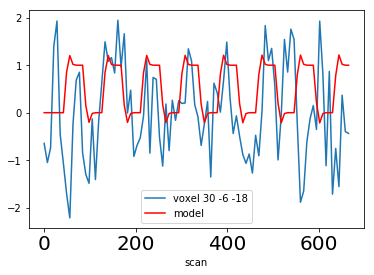

In [55]:
plt.plot(frame_times, sig, label='voxel %d %d %d' % tuple(coord_mm))
plt.plot(design_matrix['active'], color='red', label='model')
plt.xlabel('scan')
plt.legend()
plt.show()

In [61]:
design_matrix['active'].shape

(96,)

In [62]:
sig.shape

(96, 1)

In [63]:
np.corrcoef(np.squeeze(sig),design_matrix['active'] )

array([[1.        , 0.12550656],
       [0.12550656, 1.        ]])

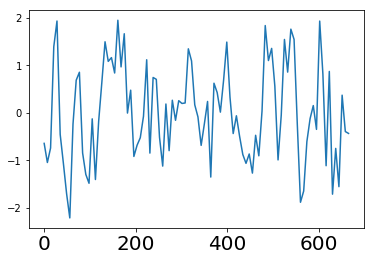

In [57]:
from nilearn.input_data import NiftiSpheresMasker
mask = NiftiSpheresMasker([coord_mm], radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None, t_r=7.)
sig2 = mask.fit_transform(f2)
plt.plot(frame_times, sig2)